In [1]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import seaborn as sns
import pandas as pd
from brokenaxes import brokenaxes
import sys
import os
import math

sys.path.append('..')
sys.path.append('../interlacer')
sys.path.append('..')
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import interlacer.utils as utils
import interlacer.layers as layers
import interlacer.models as models
import scripts.training_config as training_config
import interlacer.data_generator as data_generator
import interlacer.fastmri_data_generator as fastmri_data_generator
import interlacer.losses as losses
import scripts.filepaths as filepaths
import visualization_lib
import warnings
font_size=32

plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.family':'sans-serif'})
%matplotlib inline

In [2]:
import importlib
importlib.reload(filepaths)

<module 'scripts.filepaths' from '/data/vision/polina/scratch/nmsingh/dev/fouriernetworks/scripts/filepaths.py'>

In [3]:
exp_str = 'knee_losssweep' #knee_losssweep for non fat-saturated
base_dir = os.path.join(filepaths.TRAIN_DIR,exp_str) 
exps = os.listdir(base_dir)
exps = [i for i in exps if ('.png' not in i and '.pdf' not in i)]

In [4]:
def get_loss_label(l_t):
    if(l_t=='image'):
        return 'Image L1'
    elif(l_t=='freq'):
        return 'Freq L1'
    elif(l_t=='joint'):
        return 'Joint L1'
    elif(l_t=='ssim'):
        return '1-SSIM'
    elif(l_t=='ssim_ms'):
        return '1-Multiscale SSIM'
    elif(l_t=='psnr'):
        return '40-PSNR'

In [5]:
losses_list = ['Image L1','Freq L1','Joint L1','1-SSIM','1-Multiscale SSIM','40-PSNR']

In [6]:
n = 320
base_dir = filepaths.TRAIN_DIR

def get_model_metrics(exp_name,exp_str,run_name,m_input,m_output):
    exp_dir = base_dir+exp_name  
    config_path = base_dir + exp_name + '/' + run_name + '/' + run_name+'_config.ini'
    model_path = base_dir + exp_name + '/' + run_name
    exp_config = training_config.TrainingConfig(config_path)
    exp_config.read_config()
    
    exp_config, model = visualization_lib.load_model(config_path)
    best_epoch = visualization_lib.get_best_ckpt(model_path)
    ckptname = 'cp-'+str(best_epoch).zfill(4)+'.ckpt'

    used_loss = losses.image_loss(exp_config.output_domain,exp_config.loss) 
    image_l1 = losses.image_loss(exp_config.output_domain,'L1')
    fourier_l1 = losses.fourier_loss(exp_config.output_domain,'L1')
    joint_l1 = losses.joint_img_freq_loss(exp_config.output_domain,'L1', 0.1)

    ssim = losses.ssim(exp_config.output_domain)
    ssim_ms = losses.ssim_multiscale(exp_config.output_domain)
    lpips = losses.lpips(exp_config.output_domain)
    psnr = losses.psnr(exp_config.output_domain)

    model.compile(optimizer=keras.optimizers.Adam(),
        loss=used_loss,
        metrics=[image_l1, fourier_l1, joint_l1, ssim, ssim_ms, lpips, psnr])
    model.load_weights(os.path.join(model_path,ckptname))

    if(exp_config.output_domain=='IMAGE'):
        m_input = utils.convert_tensor_to_image_domain(m_input)
        m_output = utils.convert_tensor_to_image_domain(m_output)
    
    maes = []
    for i in range(96):
        m_input_i = tf.expand_dims(m_input[i,:,:,:],0)
        m_output_i = tf.expand_dims(m_output[i,:,:,:],0)
        maes.append(model.evaluate(m_input_i,m_output_i,verbose=0)[1:])
        
    return maes   

In [7]:

fastmri_dir = filepaths.FASTMRI_DATA_DIR
test_slice_dir = os.path.join(fastmri_dir, 'validate/singlecoil_val')
val_generator = fastmri_data_generator.generate_data(test_slice_dir, 'undersample', 'FREQ', 'FREQ', 0.75, batch_size=96)
m_input,m_output = next(val_generator)

cols = ['architecture','loss']
cols.extend(losses_list)
results = pd.DataFrame(columns = cols)

for exp in exps:
    print(exp)
    exp_dir = os.path.join(base_dir,'knee_losssweep',exp)
    config_path = os.path.join(exp_dir,exp+'_config.ini')

    exp_config = training_config.TrainingConfig(config_path)
    exp_config.read_config()

    architecture = exp_config.architecture
    input_domain = exp_config.input_domain
    num_layer = exp_config.num_layers
    activation = exp_config.nonlinearity
    corruption_frac = exp_config.corruption_frac
    
    loss_type = exp_config.loss_type

    run_name = 'FASTMRI-undersample-'+str(corruption_frac)+'-'+architecture+'-9-32-'+str(num_layer)+'-'+loss_type+'-L1-0.1-'+input_domain+'-'+input_domain+'-'+activation+'-5000-8'
    
    if(exp_config.corruption_frac=='0.75'):
        m_input,m_output = m_input_4,m_output_4
    
    metrics = get_model_metrics('knee_losssweep','undersample',run_name,m_input,m_output)  
    
    architecture = exp_config.architecture[:-9]
    if('CONV' in architecture): 
        architecture = exp_config.input_domain
    if('INTERLACER' in architecture):
        architecture = 'JOINT'
    loss = get_loss_label(exp_config.loss_type)
    
    for i in range(96):
        m_i = metrics[i]
        metrics_df = pd.DataFrame({'architecture':architecture,'loss':loss,'Image L1':m_i[0],'Freq L1':m_i[1],'Joint L1':m_i[2],'1-SSIM':1+m_i[3],'1-Multiscale SSIM':1+m_i[4],'LPIPS':m_i[5],'40-PSNR':40+m_i[6]},index=[i])
        results = results.append(metrics_df,ignore_index=True)

results.to_csv('summary_data_cvpr_comp_img/'+exp_str+'_val.csv')
        


FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-ssim_ms-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-image-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-psnr-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-ssim-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-freq-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-joint-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-freq-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-freq-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-lpips-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-joint-L1-0.1-FREQ-FREQ-3-piece-5000-8


FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-freq-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-ssim-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-psnr-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-psnr-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-ssim-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-ssim-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-image-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-joint-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-lpips-L1-0.1-FREQ-FREQ-3-piece-5000-8


FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-image-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-ALTERNATING_RESIDUAL-9-32-8-ssim_ms-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-image-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-psnr-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-lpips-L1-0.1-IMAGE-IMAGE-relu-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-ssim_ms-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-INTERLACER_RESIDUAL-9-32-8-lpips-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-ssim_ms-L1-0.1-FREQ-FREQ-3-piece-5000-8
FASTMRI-undersample-0.75-CONV_RESIDUAL-9-32-16-joint-L1-0.1-IMAGE-IMAGE-relu-5000-8


FileNotFoundError: [Errno 2] No such file or directory: 'summary_data_cvpr_comp_img/knee_losssweep_val.csv'

In [11]:
results.to_csv('summary_data_cvpr_comp_img/'+exp_str+'_val.csv')

In [12]:
for df in [results]:
    df.replace(to_replace='ALTERNATING', value='Alternating', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='JOINT', value='Interleaved', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='IMAGE', value='Image', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='FREQ', value='Frequency', inplace=True, limit=None, regex=False, method='pad')

In [13]:
df.replace(to_replace='1-Multiscale SSIM', value='1-SSIM-ms', inplace=True, limit=None, regex=False, method='pad')
losses_list = ['Image L1','Freq L1','Joint L1','1-SSIM','1-SSIM-ms','40-PSNR']
df['1-SSIM-ms']=df['1-Multiscale SSIM']

Text(0.0, 0.5, 'Evaluation Metric')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


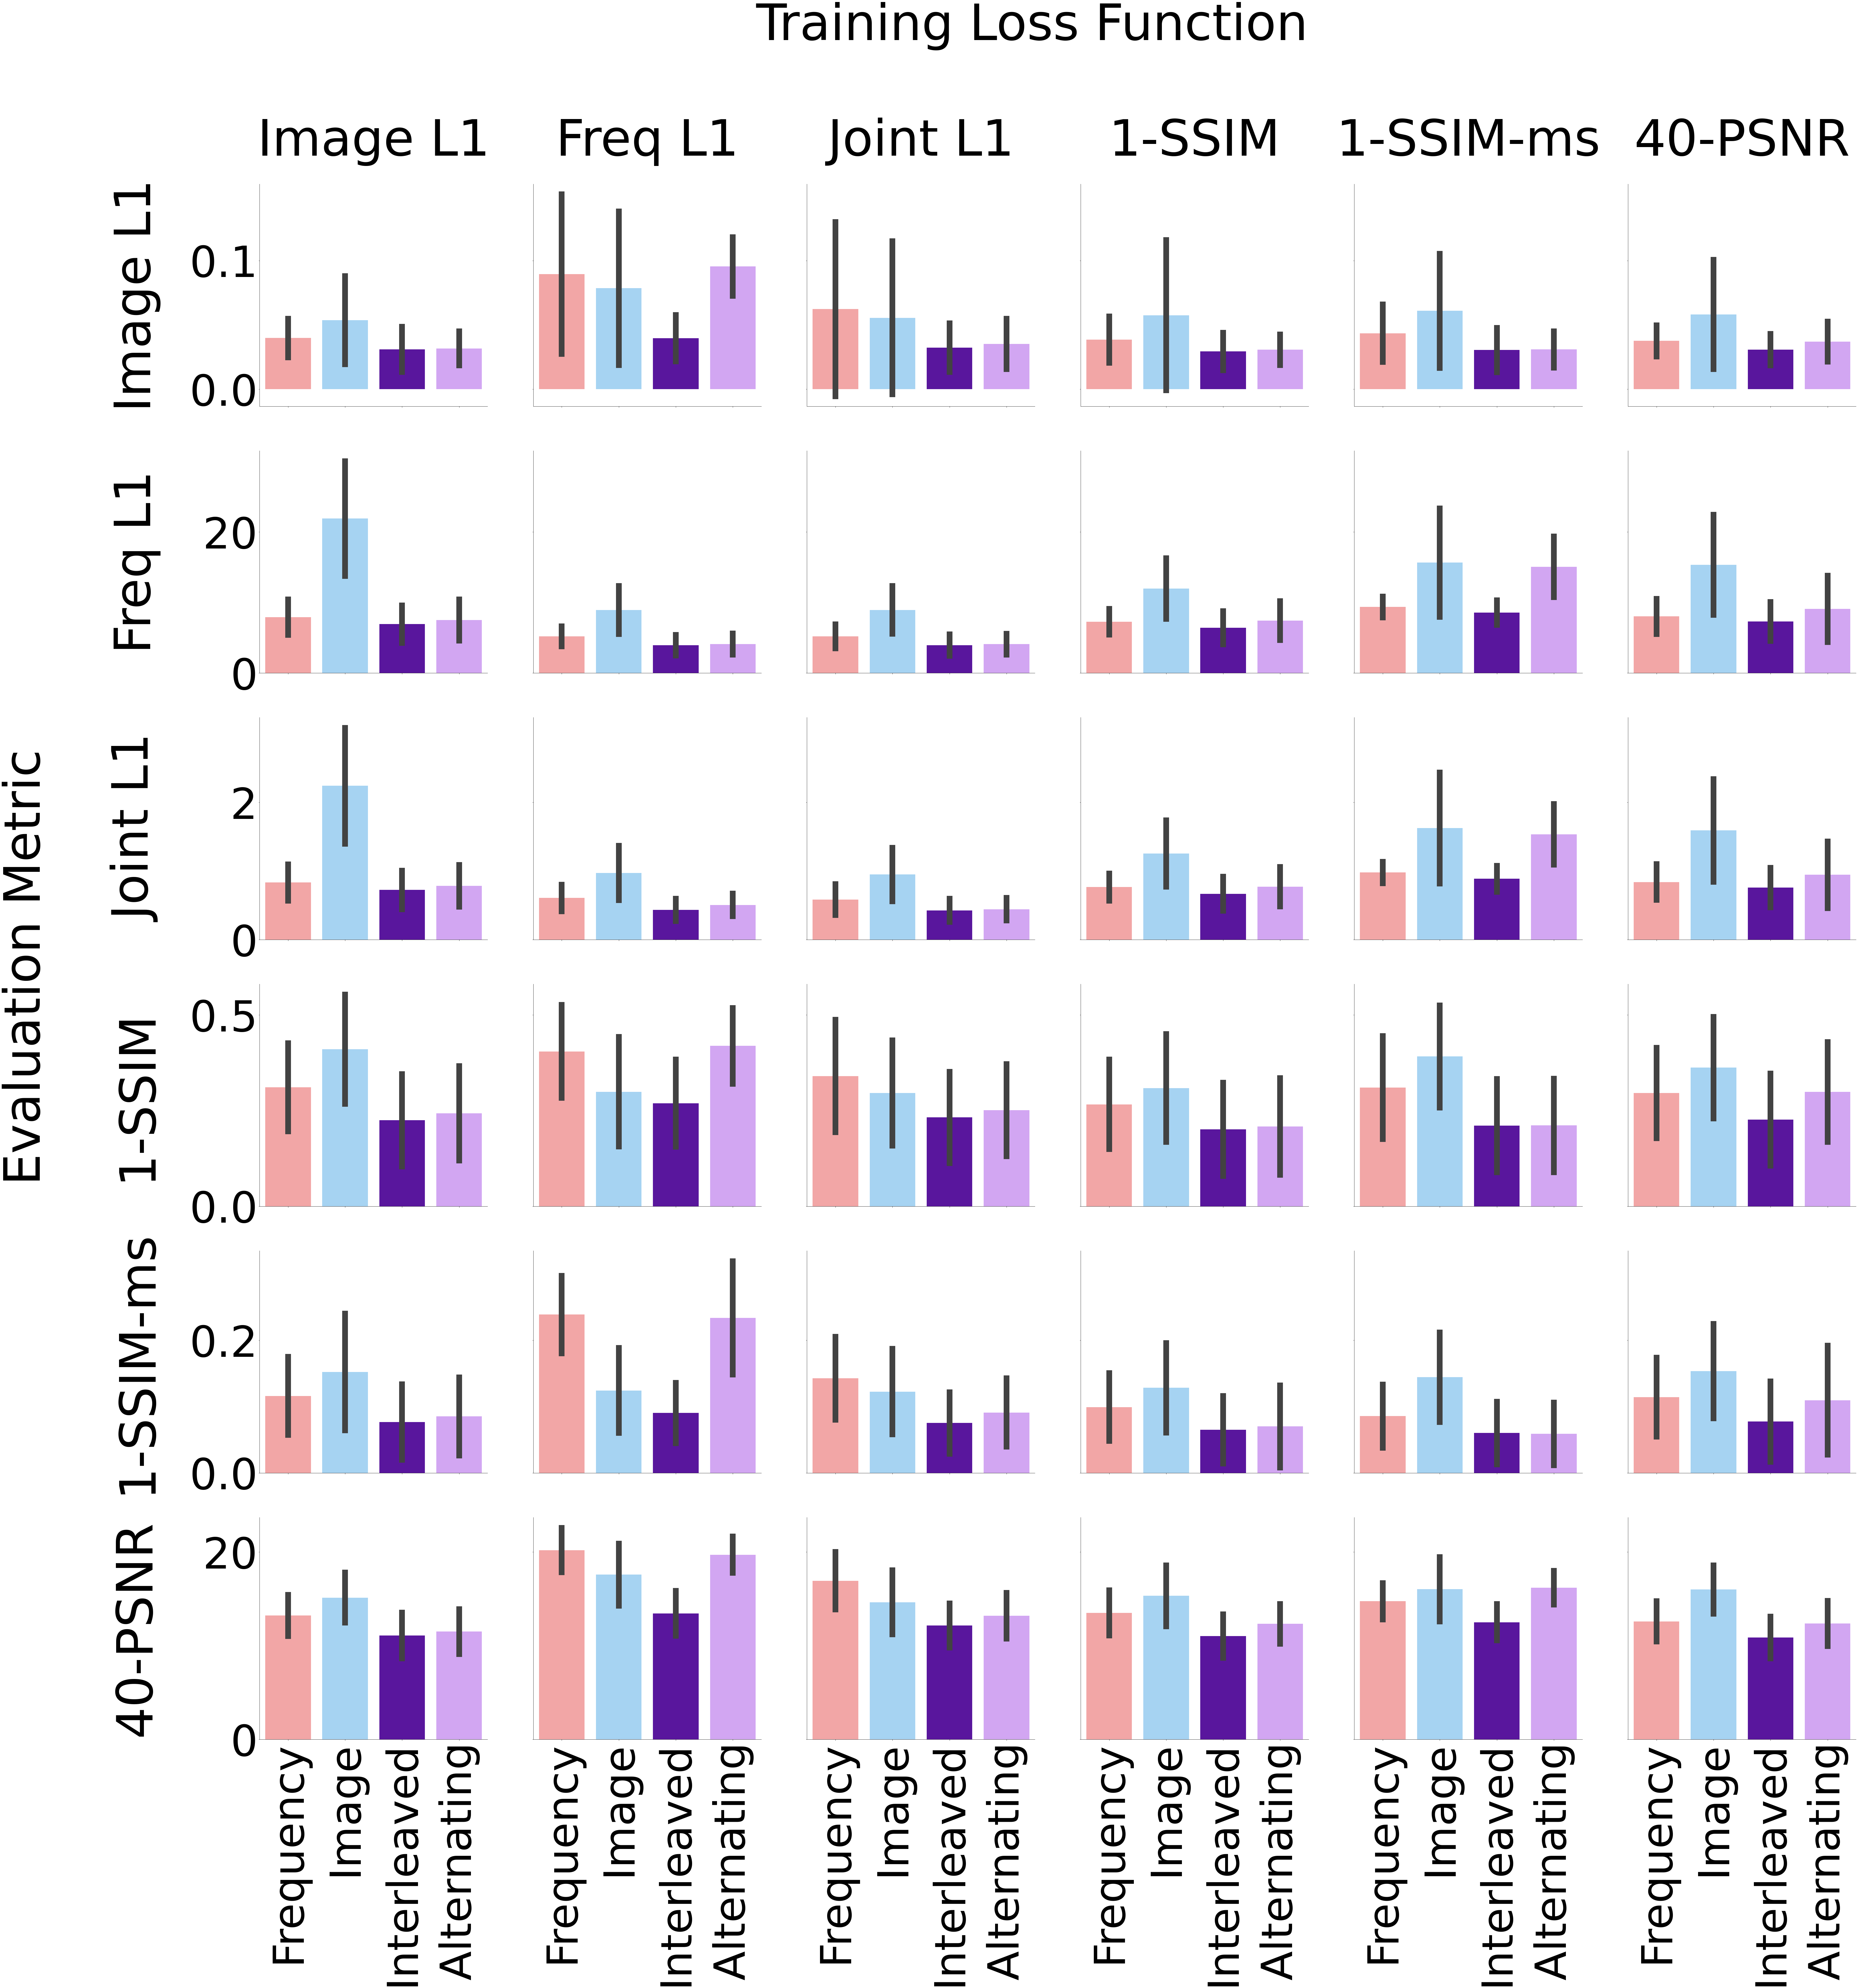

In [14]:
plt.rcParams.update({'font.size': 175})

f, axes = plt.subplots(6, 6, figsize=(100,100),sharey='row',sharex='col')
hue_order = ['Frequency','Image','Interleaved','Alternating']
palette = ['#ff9999','#99d6ff','#5900b3','#d499ff']


for i in range(6):
    for j in range(6):
        sns.barplot('architecture',losses_list[i],data=results[results['loss']==losses_list[j]],ax=axes[i][j],order=hue_order, ci='sd', hue_order = hue_order, palette = palette, errwidth=20)
        
        ax = axes[i][j]
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        
        ax.set_xlabel('')
        ax.set_ylabel('',labelpad=100)        

        
        if(i==0):
            ax.set_title(losses_list[j],size=175,pad=100)
        
        if(i!=5):
            for tk in ax.get_xticklabels():
                tk.set_visible(False)
        else:
            for tk in ax.get_xticklabels():
                tk.set_visible(True)
                tk.set_rotation(90)
                tk.set_size(150)
                
        if(j==0):
            ax.set_ylabel(losses_list[i])
            for tk in ax.get_yticklabels():
                tk.set_visible(True)
                tk.set_size(150)
        else:
            for tk in ax.get_yticklabels():
                tk.set_visible(False)
f.align_ylabels(axes[:, 0])


f.text(0.5, 0.95, 'Training Loss Function', ha='center')
f.text(0.0, 0.5, 'Evaluation Metric', va='center', rotation='vertical')

In [278]:
results

,architecture,loss,Image L1,Freq L1,Joint L1,1-SSIM,1-Multiscale SSIM,40-PSNR,LPIPS,1-SSIM-ms
0,Image,1-SSIM-ms,0.068714,17.815699,1.850284,0.430620,0.162160,16.675159,0.413814,0.162160
1,Image,1-SSIM-ms,0.055300,14.116076,1.466907,0.358700,0.175057,16.641033,0.499270,0.175057
2,Image,1-SSIM-ms,0.068333,18.957546,1.964087,0.485726,0.165730,16.966032,0.385016,0.165730
3,Image,1-SSIM-ms,0.057309,13.832275,1.440536,0.433673,0.167076,16.606724,0.431012,0.167076
4,Image,1-SSIM-ms,0.045564,12.597221,1.305286,0.311298,0.128166,13.878284,0.403176,0.128166
...,...,...,...,...,...,...,...,...,...,...
2683,Image,Joint L1,0.052486,8.284338,0.880920,0.479482,0.113970,15.424181,0.560713,0.113970
2684,Image,Joint L1,0.032399,4.963569,0.528756,0.141374,0.075597,10.248072,0.354815,0.075597
2685,Image,Joint L1,0.040088,6.692490,0.709337,0.280924,0.100030,13.881338,0.339761,0.100030
2686,Image,Joint L1,0.060581,9.570482,1.017630,0.388550,0.087811,16.029867,0.380867,0.087811


In [16]:
results_cp = results.copy()

In [323]:
latex_results_df = results.groupby([results.loss, results.architecture]).mean()
latex_results_std_df = results.groupby([results.loss, results.architecture]).std()

digs = [1,3,2,2,2,1]

def conglomerate_df(df,std=False):
    ind_list = []
    for i in [3,4,5,0,1,2]:
        for j in [1,2,3,0]:
            ind_list.append(df.index[i*4+j])
    df = df.reindex(ind_list)
    
    cols = ['Freq L1', 'Image L1', 'Joint L1','1-SSIM','1-Multiscale SSIM','40-PSNR']
    df = df[cols]
    
    if(not std):
        df['SSIM'] = 1-df['1-SSIM']
        df['MS SSIM'] = 1-df['1-Multiscale SSIM']
        df['PSNR'] = 40-df['40-PSNR']
    else:
        df['SSIM'] = df['1-SSIM']
        df['MS SSIM'] = df['1-Multiscale SSIM']
        df['PSNR'] = df['40-PSNR']
    df.drop(columns=['1-SSIM','1-Multiscale SSIM','40-PSNR'], inplace=True)
    df.rename({'1-SSIM':'-SSIM','1-SSIM-ms':'-MS SSIM','40-PSNR':'-PSNR'}, inplace=True)
    
    
    for i in range(len(df.columns)):
        col = df.columns[i]
        df[col] = df[col].round(digs[i])
    return df

latex_results_df = conglomerate_df(latex_results_df)
latex_results_std_df = conglomerate_df(latex_results_std_df,True)
    

In [ ]:
latex_results_df['SSIM']

In [288]:
latex_results_std_df

Freq L1  Image L1  Joint L1  SSIM  MS SSIM  PSNR
loss     architecture                                                  
Freq L1  Frequency         1.4     0.063      0.19  0.12     0.06   2.4
         Image             3.4     0.060      0.40  0.14     0.06   3.3
         Interleaved       1.5     0.018      0.16  0.11     0.05   2.4
         Alternating       1.5     0.023      0.16  0.10     0.09   1.9
Image L1 Frequency         2.5     0.015      0.27  0.12     0.06   2.2
         Image             8.2     0.034      0.85  0.14     0.09   2.7
         Interleaved       2.7     0.018      0.28  0.12     0.06   2.5
         Alternating       2.9     0.013      0.31  0.12     0.06   2.4
Joint L1 Frequency         1.7     0.068      0.23  0.15     0.06   3.1
         Image             3.4     0.060      0.39  0.14     0.06   3.4
         Interleaved       1.5     0.019      0.17  0.12     0.05   2.4
         Alternating       1.5     0.020      0.17  0.12     0.05   2.5
-SSIM    Frequency         1.8     0.018      0.20  0.12     0.05   2.4
         Image             4.3     0.059      0.49  0.14     0.07   3.3
         Interleaved       2.4     0.015      0.25  0.12     0.05   2.3
         Alternating       2.8     0.012      0.29  0.13     0.06   2.1
-MS SSIM Frequency         1.5     0.023      0.16  0.14     0.05   2.0
         Image             7.7     0.045      0.81  0.13     0.07   3.5
         Interleaved       1.8     0.017      0.19  0.12     0.05   1.9
         Alternating       4.3     0.014      0.44  0.12     0.05   1.8
-PSNR    Frequency         2.5     0.012      0.26  0.12     0.06   2.2
         Image             7.1     0.043      0.75  0.13     0.07   2.6
         Interleaved       2.8     0.012      0.29  0.12     0.06   2.2
         Alternating       4.7     0.016      0.49  0.13     0.08   2.4

In [289]:
cols = latex_results_df.columns
rows = latex_results_df.index.get_level_values(0)[::4]

In [290]:
print(rows)
print(cols)

Index(['Freq L1', 'Image L1', 'Joint L1', '-SSIM', '-MS SSIM', '-PSNR'], dtype='object', name='loss')
Index(['Freq L1', 'Image L1', 'Joint L1', 'SSIM', 'MS SSIM', 'PSNR'], dtype='object')


In [333]:
rows

Index(['Freq L1', 'Image L1', 'Joint L1', '-SSIM', '-MS SSIM', '-PSNR'], dtype='object', name='loss')

In [395]:
table = list(r'\begin{tabularx}{\textwidth}{CC')

for col in cols:
    table.append('X')
table[-1] = r'X} \n \Xhline{2\arrayrulewidth} \textbf{Loss} & \textbf{Architecture} &'

for col in cols:
    if(col in ['PSNR','SSIM','MS SSIM']):
        arr = r'\uparrow'
    else:
        arr = r'\downarrow'
    table.append(r'\thead{\textbf{'+col +' ($' + arr + '$)'+ '}}')
    table.append(' &')
table[-1] = r'\\ \hline'

table.append(' \n')

for r, row in enumerate(rows):
    table.append(row + ' & ')
    
    arch_string = r'\makecell{Frequency \\ Image \\ Interleaved \\ Alternating}'
    table.append(arch_string + ' &')    
    for c,col in enumerate(cols):

        col_str = list(r'\makecell{')
        for i in range(4):
            dec_str = '{0:.'+str(digs[c])+'f}'
            val = latex_results_df[col][row][i]
            if(val<10):
                col_str.append('~')
            
            bold=False
            if(c<3):
                if(sum([val<=latex_results_df[col][row][x] for x in range(4)])==4):
                    bold=True
                    col_str.append(r'\textbf{')
            else:
                if(sum([val>=latex_results_df[col][row][x] for x in range(4)])==4):
                    bold=True
                    col_str.append(r'\textbf{')
            col_str.append(dec_str.format(latex_results_df[col][row][i]) + ' $\pm$ ' + dec_str.format(latex_results_std_df[col][row][i]))
            if(bold):
                col_str.append('}')
            if(i!=3):                
                col_str.append(r' \\ ')
        col_str.append('}')
        col_str = ''.join(col_str)
        
        if(col!='PSNR'):
            table.append(str(col_str+ ' & '))
        else:
            table.append(str(col_str+ ' & '))
    table.append(r'\hline')
    table.append(' \n')

table.append(r'\end{tabularx}')

table = ''.join(table)
#for r in range(len(rows)):
#    ta
#    for c in range(len(columns)):
        

In [396]:
print(table)

\begin{tabularx}{\textwidth}{CCXXXXXX} \n \Xhline{2\arrayrulewidth} \textbf{Loss} & \textbf{Architecture} &\thead{\textbf{Freq L1 ($\downarrow$)}} &\thead{\textbf{Image L1 ($\downarrow$)}} &\thead{\textbf{Joint L1 ($\downarrow$)}} &\thead{\textbf{SSIM ($\uparrow$)}} &\thead{\textbf{MS SSIM ($\uparrow$)}} &\thead{\textbf{PSNR ($\uparrow$)}}\\ \hline 
Freq L1 & \makecell{Frequency \\ Image \\ Interleaved \\ Alternating} &\makecell{~5.2 $\pm$ 1.4 \\ ~8.9 $\pm$ 3.4 \\ ~\textbf{3.9 $\pm$ 1.5} \\ ~4.1 $\pm$ 1.5} & \makecell{~0.089 $\pm$ 0.063 \\ ~0.079 $\pm$ 0.060 \\ ~\textbf{0.040 $\pm$ 0.018} \\ ~0.095 $\pm$ 0.023} & \makecell{~0.61 $\pm$ 0.19 \\ ~0.97 $\pm$ 0.40 \\ ~\textbf{0.43 $\pm$ 0.16} \\ ~0.51 $\pm$ 0.16} & \makecell{~0.60 $\pm$ 0.12 \\ ~0.70 $\pm$ 0.14 \\ ~\textbf{0.73 $\pm$ 0.11} \\ ~0.58 $\pm$ 0.10} & \makecell{~0.76 $\pm$ 0.06 \\ ~0.88 $\pm$ 0.06 \\ ~\textbf{0.91 $\pm$ 0.05} \\ ~0.77 $\pm$ 0.09} & \makecell{19.8 $\pm$ 2.4 \\ 22.4 $\pm$ 3.3 \\ \textbf{26.6 $\pm$ 2.4} \\ 20.3 $\pm

In [303]:
'(' + arr + ')'+

Freq L1  Image L1  Joint L1  SSIM  MS SSIM  PSNR
loss     architecture                                                  
Freq L1  Frequency         5.2     0.089      0.61  0.60     0.76  19.8
         Image             8.9     0.079      0.97  0.70     0.88  22.4
         Interleaved       3.9     0.040      0.43  0.73     0.91  26.6
         Alternating       4.1     0.095      0.51  0.58     0.77  20.3
Image L1 Frequency         7.9     0.040      0.83  0.69     0.88  26.8
         Image            21.9     0.054      2.24  0.59     0.85  24.9
         Interleaved       6.9     0.031      0.72  0.78     0.92  28.9
         Alternating       7.5     0.032      0.78  0.76     0.91  28.5
Joint L1 Frequency         5.2     0.062      0.58  0.66     0.86  23.1
         Image             8.9     0.055      0.95  0.70     0.88  25.4
         Interleaved       3.9     0.032      0.43  0.77     0.92  27.8
         Alternating       4.1     0.035      0.44  0.75     0.91  26.8
-SSIM    Frequency         7.3     0.039      0.76  0.73     0.90  26.5
         Image            12.0     0.058      1.25  0.69     0.87  24.7
         Interleaved       6.4     0.029      0.67  0.80     0.94  29.0
         Alternating       7.4     0.031      0.77  0.79     0.93  27.7
-MS SSIM Frequency         9.3     0.043      0.98  0.69     0.91  25.3
         Image            15.6     0.061      1.63  0.61     0.86  24.0
         Interleaved       8.6     0.030      0.89  0.79     0.94  27.5
         Alternating      15.0     0.031      1.54  0.79     0.94  23.8
-PSNR    Frequency         8.0     0.038      0.84  0.70     0.89  27.4
         Image            15.3     0.058      1.59  0.64     0.85  24.0
         Interleaved       7.3     0.031      0.76  0.77     0.92  29.1
         Alternating       9.1     0.037      0.95  0.70     0.89  27.6

In [42]:
latex_results_df.reindex(ind_list)

Image L1    Freq L1  Joint L1    1-SSIM  \
loss      architecture                                            
Freq L1   Frequency     0.089455   5.175926  0.607047  0.404552   
          Image         0.078513   8.921020  0.970615  0.299114   
          Interleaved   0.039576   3.927314  0.432307  0.269066   
          Alternating   0.095402   4.097038  0.505105  0.419036   
Image L1  Frequency     0.039768   7.915436  0.831311  0.310882   
          Image         0.053661  21.882008  2.241862  0.410186   
          Interleaved   0.030977   6.922682  0.723245  0.224450   
          Alternating   0.031708   7.516006  0.783309  0.243011   
Joint L1  Frequency     0.062254   5.197704  0.582024  0.340209   
          Image         0.055445   8.932651  0.948711  0.295807   
          Interleaved   0.032218   3.942534  0.426472  0.231931   
          Alternating   0.035174   4.078143  0.442988  0.250856   
1-SSIM    Frequency     0.038544   7.264497  0.764994  0.266192   
          Image         0.057513  11.964921  1.254005  0.308659   
          Interleaved   0.029284   6.392394  0.668523  0.200925   
          Alternating   0.030645   7.410869  0.771732  0.208367   
1-SSIM-ms Frequency     0.043469   9.348376  0.978307  0.309838   
          Image         0.060900  15.641391  1.625039  0.391201   
          Interleaved   0.030404   8.565547  0.886959  0.210834   
          Alternating   0.030861  15.046597  1.535521  0.211125   
40-PSNR   Frequency     0.037525   8.011006  0.838625  0.295732   
          Image         0.058093  15.324570  1.590550  0.362114   
          Interleaved   0.030715   7.287487  0.759463  0.226543   
          Alternating   0.036915   9.083976  0.945312  0.298492   

                        1-Multiscale SSIM    40-PSNR     LPIPS  1-SSIM-ms  
loss      architecture                                                     
Freq L1   Frequency              0.238798  20.192710  0.796188   0.238798  
          Image                  0.124284  17.573444  0.348471   0.124284  
          Interleaved            0.090267  13.445968  0.625612   0.090267  
          Alternating            0.233811  19.699725  0.724195   0.233811  
Image L1  Frequency              0.116150  13.213872  0.357786   0.116150  
          Image                  0.152032  15.131138  0.392097   0.152032  
          Interleaved            0.076487  11.080732  0.282669   0.076487  
          Alternating            0.085243  11.506217  0.265501   0.085243  
Joint L1  Frequency              0.142726  16.920398  0.736493   0.142726  
          Image                  0.122528  14.629735  0.365450   0.122528  
          Interleaved            0.075318  12.153944  0.593550   0.075318  
          Alternating            0.091088  13.188306  0.654373   0.091088  
1-SSIM    Frequency              0.099311  13.504461  0.398639   0.099311  
          Image                  0.128282  15.315969  0.388779   0.128282  
          Interleaved            0.064862  11.034791  0.361663   0.064862  
          Alternating            0.070014  12.331835  0.531331   0.070014  
1-SSIM-ms Frequency              0.085536  14.737711  0.681046   0.085536  
          Image                  0.144259  16.025307  0.382695   0.144259  
          Interleaved            0.060044  12.503249  0.555783   0.060044  
          Alternating            0.058856  16.186372  0.631497   0.058856  
40-PSNR   Frequency              0.114249  12.592104  0.339829   0.114249  
          Image                  0.153420  15.985488  0.366554   0.153420  
          Interleaved            0.077318  10.880388  0.212567   0.077318  
          Alternating            0.109489  12.377125  0.286172   0.109489

In [25]:
latex_results_df.sort_values([(index.loss, index.architecture)], ascending=False)

NameError: name 'index' is not defined

In [33]:
f.savefig(exp_str+'_plots.pdf')